# FBA Optimization: Acetyl-CoA to Fatty Acids

This notebook demonstrates FBA optimization for fatty acid production from acetyl-CoA using existing pathways in the E. coli iML1515 model.

## Key Features
- Uses existing fatty acid CoA metabolites (btcoa_c, hxcoa_c, occoa_c, etc.)
- Leverages existing pathways in the model
- Produces real, non-zero production rates
- Includes pathway analysis and knockout screening

In [1]:
# Import required libraries
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cobra.flux_analysis import flux_variability_analysis
from cobra.core import Reaction, Metabolite

# Import our FBA optimizer
from fba_optimizer import WorkingFBAOptimizer

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Initialize FBA Optimizer

Load the E. coli iML1515 model and check existing fatty acid CoA metabolites.

In [2]:
# Initialize the FBA optimizer
optimizer = WorkingFBAOptimizer()

print(f"Model: {optimizer.model.id}")
print(f"Reactions: {len(optimizer.model.reactions)}")
print(f"Metabolites: {len(optimizer.model.metabolites)}")

# Show the fatty acid mapping
print("\nFatty acid CoA metabolites available:")
for name, met_id in optimizer.fatty_acid_map.items():
    try:
        met = optimizer.model.metabolites.get_by_id(met_id)
        print(f"  {name}: {met.name} ({met_id})")
    except KeyError:
        print(f"  {name}: {met_id} (NOT FOUND)")

INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:fba_optimizer:Loaded model: iML1515
INFO:fba_optimizer:Reactions: 2712, Metabolites: 1877
INFO:fba_optimizer:Checking existing fatty acid CoA metabolites...
INFO:fba_optimizer:  butanoic_acid: Butanoyl-CoA (btcoa_c)
INFO:fba_optimizer:  hexanoic_acid: Hexanoyl-CoA (n-C6:0CoA) (hxcoa_c)
INFO:fba_optimizer:  octanoic_acid: Octanoyl-CoA (n-C8:0CoA) (occoa_c)
INFO:fba_optimizer:  decanoic_acid: Decanoyl-CoA (n-C10:0CoA) (dcacoa_c)
INFO:fba_optimizer:  dodecanoic_acid: Dodecanoyl-CoA (n-C12:0CoA) (ddcacoa_c)
INFO:fba_optimizer:  tetradecanoic_acid: Tetradecanoyl-CoA (n-C14:0CoA) (tdcoa_c)


Model: iML1515
Reactions: 2712
Metabolites: 1877

Fatty acid CoA metabolites available:
  butanoic_acid: Butanoyl-CoA (btcoa_c)
  hexanoic_acid: Hexanoyl-CoA (n-C6:0CoA) (hxcoa_c)
  octanoic_acid: Octanoyl-CoA (n-C8:0CoA) (occoa_c)
  decanoic_acid: Decanoyl-CoA (n-C10:0CoA) (dcacoa_c)
  dodecanoic_acid: Dodecanoyl-CoA (n-C12:0CoA) (ddcacoa_c)
  tetradecanoic_acid: Tetradecanoyl-CoA (n-C14:0CoA) (tdcoa_c)


## 2. Add Demand Reactions

Add demand reactions for all fatty acid CoA metabolites to enable optimization.

In [3]:
# Add demand reactions for all fatty acid CoA metabolites
optimizer.add_demand_reactions()

print("\nDemand reactions added:")
for name, demand_id in optimizer.demand_reactions.items():
    print(f"  {name}: {demand_id}")

print(f"\nTotal demand reactions: {len(optimizer.demand_reactions)}")

INFO:fba_optimizer:Adding demand reactions for fatty acid CoA metabolites...
INFO:fba_optimizer:  Added demand for butanoic_acid: DM_btcoa_c
INFO:fba_optimizer:  Added demand for hexanoic_acid: DM_hxcoa_c
INFO:fba_optimizer:  Added demand for octanoic_acid: DM_occoa_c
INFO:fba_optimizer:  Added demand for decanoic_acid: DM_dcacoa_c
INFO:fba_optimizer:  Added demand for dodecanoic_acid: DM_ddcacoa_c
INFO:fba_optimizer:  Added demand for tetradecanoic_acid: DM_tdcoa_c



Demand reactions added:
  butanoic_acid: DM_btcoa_c
  hexanoic_acid: DM_hxcoa_c
  octanoic_acid: DM_occoa_c
  decanoic_acid: DM_dcacoa_c
  dodecanoic_acid: DM_ddcacoa_c
  tetradecanoic_acid: DM_tdcoa_c

Total demand reactions: 6


## 3. Optimize All Fatty Acids

Run FBA optimization for all available fatty acids and compare production rates.

In [4]:
# Optimize production for all fatty acids
print("Optimizing production for all fatty acids...")
print("="*60)

results = optimizer.optimize_all_fatty_acids()

# Display results
print("\nOptimization Results:")
print("-" * 60)
results_data = []
for fatty_acid, result in results.items():
    production_rate = result['production_rate']
    growth_rate = result.get('growth_rate', 0)
    glucose_uptake = result.get('glucose_uptake', 0)
    yield_val = result.get('yield_mol_per_mol_glucose', 0)
    status = result['status']
    
    results_data.append({
        'Fatty Acid': fatty_acid,
        'Production Rate (mmol/gDW/h)': production_rate,
        'Growth Rate (h⁻¹)': growth_rate,
        'Glucose Uptake (mmol/gDW/h)': glucose_uptake,
        'Yield (mol/mol glucose)': yield_val,
        'Status': status
    })
    
    print(f"{fatty_acid:20s}: {production_rate:8.4f} mmol/gDW/h ({status})")

# Create results DataFrame
results_df = pd.DataFrame(results_data)
print("\nDetailed Results:")
print(results_df.to_string(index=False))

INFO:fba_optimizer:Optimizing production for all fatty acids...
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.


Optimizing production for all fatty acids...


INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization successful for butanoic_acid
INFO:fba_optimizer:Production rate: 1.7445 mmol/gDW/h
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization successful for hexanoic_acid
INFO:fba_optimizer:Production rate: 1.6131 mmol/gDW/h
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization successful for octanoic_acid
INFO:fba_optimizer:Production rate: 1.5001 mmol/gDW/h
INFO:cobra.core.model:The cur


Optimization Results:
------------------------------------------------------------
butanoic_acid       :   1.7445 mmol/gDW/h (optimal)
hexanoic_acid       :   1.6131 mmol/gDW/h (optimal)
octanoic_acid       :   1.5001 mmol/gDW/h (optimal)
decanoic_acid       :   1.4016 mmol/gDW/h (optimal)
dodecanoic_acid     :   1.3145 mmol/gDW/h (optimal)
tetradecanoic_acid  :   1.2374 mmol/gDW/h (optimal)

Detailed Results:
        Fatty Acid  Production Rate (mmol/gDW/h)  Growth Rate (h⁻¹)  Glucose Uptake (mmol/gDW/h)  Yield (mol/mol glucose)  Status
     butanoic_acid                      1.744489                0.0                         10.0                 0.174449 optimal
     hexanoic_acid                      1.613088                0.0                         10.0                 0.161309 optimal
     octanoic_acid                      1.500090                0.0                         10.0                 0.150009 optimal
     decanoic_acid                      1.401578                0

## 4. Analyze Best Performing Fatty Acid

Identify the best performing fatty acid and analyze its production pathway.

In [5]:
# Find best performing fatty acid
best_fatty_acid = max(results.keys(), key=lambda x: results[x]['production_rate'])
best_result = results[best_fatty_acid]

print(f"Best Performing Fatty Acid: {best_fatty_acid}")
print("="*50)
print(f"Production Rate: {best_result['production_rate']:.4f} mmol/gDW/h")
print(f"Growth Rate: {best_result['growth_rate']:.4f} h⁻¹")
print(f"Glucose Uptake: {best_result['glucose_uptake']:.4f} mmol/gDW/h")
print(f"Yield: {best_result['yield_mol_per_mol_glucose']:.4f} mol/mol glucose")

# Analyze pathway usage
print("\nPathway Analysis:")
print("-" * 30)
pathway_analysis = optimizer.analyze_pathway_usage(best_fatty_acid)

if 'error' not in pathway_analysis:
    print(f"Total active reactions: {pathway_analysis['total_active_reactions']}")
    print(f"Key pathways: {', '.join(pathway_analysis['key_pathways'])}")
    print(f"Target fatty acid reactions: {len(pathway_analysis['target_fatty_acid_reactions'])}")
    
    # Show reactions involving the target fatty acid
    print("\nReactions involving target fatty acid:")
    for rxn_id, rxn_data in pathway_analysis['target_fatty_acid_reactions'].items():
        print(f"  {rxn_id}: {rxn_data['name']} (flux: {rxn_data['flux']:.4f})")
        print(f"    {rxn_data['reaction']}")
else:
    print(f"Error in pathway analysis: {pathway_analysis['error']}")

INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.


Best Performing Fatty Acid: butanoic_acid
Production Rate: 1.7445 mmol/gDW/h
Growth Rate: 0.0000 h⁻¹
Glucose Uptake: 10.0000 mmol/gDW/h
Yield: 0.1744 mol/mol glucose

Pathway Analysis:
------------------------------


INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization successful for butanoic_acid
INFO:fba_optimizer:Production rate: 1.7445 mmol/gDW/h


Total active reactions: 118
Key pathways: Glycolysis, TCA Cycle, Acetyl-CoA
Target fatty acid reactions: 2

Reactions involving target fatty acid:
  DM_btcoa_c: butanoic_acid demand (flux: 1.7445)
    btcoa_c --> 
  ACOAD1fr: Acyl-CoA dehydrogenase (butanoyl-CoA) (flux: 1.7445)
    b2coa_c + fadh2_c --> btcoa_c + fad_c


## 5. Knockout Screening

Screen gene knockouts to identify strategies for improving fatty acid production.

In [6]:
# Screen knockouts for the best performing fatty acid
print(f"Knockout Screening for {best_fatty_acid}")
print("="*50)

# Define knockout candidates
knockout_candidates = [
    'ACALD',    # Acetaldehyde dehydrogenase (competes for acetyl-CoA)
    'ALCD2x',   # Alcohol dehydrogenase
    'PTAr',     # Phosphotransacetylase (acetate pathway)
    'ACKr',     # Acetate kinase (acetate pathway)
    'LDH_D',    # Lactate dehydrogenase (lactate pathway)
    'PFL',      # Pyruvate formate lyase (formate pathway)
    'FRD7',     # Fumarate reductase
    'SUCDi',    # Succinate dehydrogenase
    'PPCK'      # Phosphoenolpyruvate carboxykinase
]

knockout_results = optimizer.screen_knockouts(best_fatty_acid, knockout_candidates)

print("\nKnockout Screening Results:")
print("-" * 60)
print(knockout_results.to_string(index=False))

# Show top improvements
top_improvements = knockout_results[knockout_results['improvement'] > 0].head(3)
if not top_improvements.empty:
    print("\nTop Improvements:")
    print("-" * 30)
    for _, row in top_improvements.iterrows():
        print(f"  {row['knockouts']}: +{row['improvement']:.1f}% improvement")
        print(f"    Production: {row['production_rate']:.4f} mmol/gDW/h")
        print(f"    Growth: {row['growth_rate']:.4f} h⁻¹")
else:
    print("\nNo significant improvements found with tested knockouts.")
    print("This suggests the current pathway is already well-optimized.")

INFO:fba_optimizer:Screening knockouts for butanoic_acid...
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization successful for butanoic_acid


Knockout Screening for butanoic_acid


INFO:fba_optimizer:Production rate: 1.7445 mmol/gDW/h
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Knocked out: ACALD
INFO:fba_optimizer:Optimization successful for butanoic_acid
INFO:fba_optimizer:Production rate: 1.7445 mmol/gDW/h
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Knocked out: ALCD2x
INFO:fba_optimizer:Optimization successful for butanoic_acid
INFO:fba_optimizer:Production rate: 1.7445 mmol/gDW/h
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment 


Knockout Screening Results:
------------------------------------------------------------
knockouts  production_rate  growth_rate   improvement
    ACALD         1.744489          0.0  2.036535e-13
     PPCK         1.744489          0.0  1.909251e-13
   ALCD2x         1.744489          0.0  1.018267e-13
      PFL         1.744489          0.0  5.091337e-14
     none         1.744489          0.0  0.000000e+00
    LDH_D         1.744489          0.0  0.000000e+00
     FRD7         1.744489          0.0  0.000000e+00
    SUCDi         1.740911          0.0 -2.051278e-01
     PTAr         1.731723          0.0 -7.317966e-01
     ACKr         1.731723          0.0 -7.317966e-01

Top Improvements:
------------------------------
  ACALD: +0.0% improvement
    Production: 1.7445 mmol/gDW/h
    Growth: 0.0000 h⁻¹
  PPCK: +0.0% improvement
    Production: 1.7445 mmol/gDW/h
    Growth: 0.0000 h⁻¹
  ALCD2x: +0.0% improvement
    Production: 1.7445 mmol/gDW/h
    Growth: 0.0000 h⁻¹


## 6. Visualization

Create visualizations to compare fatty acid production rates and analyze results.

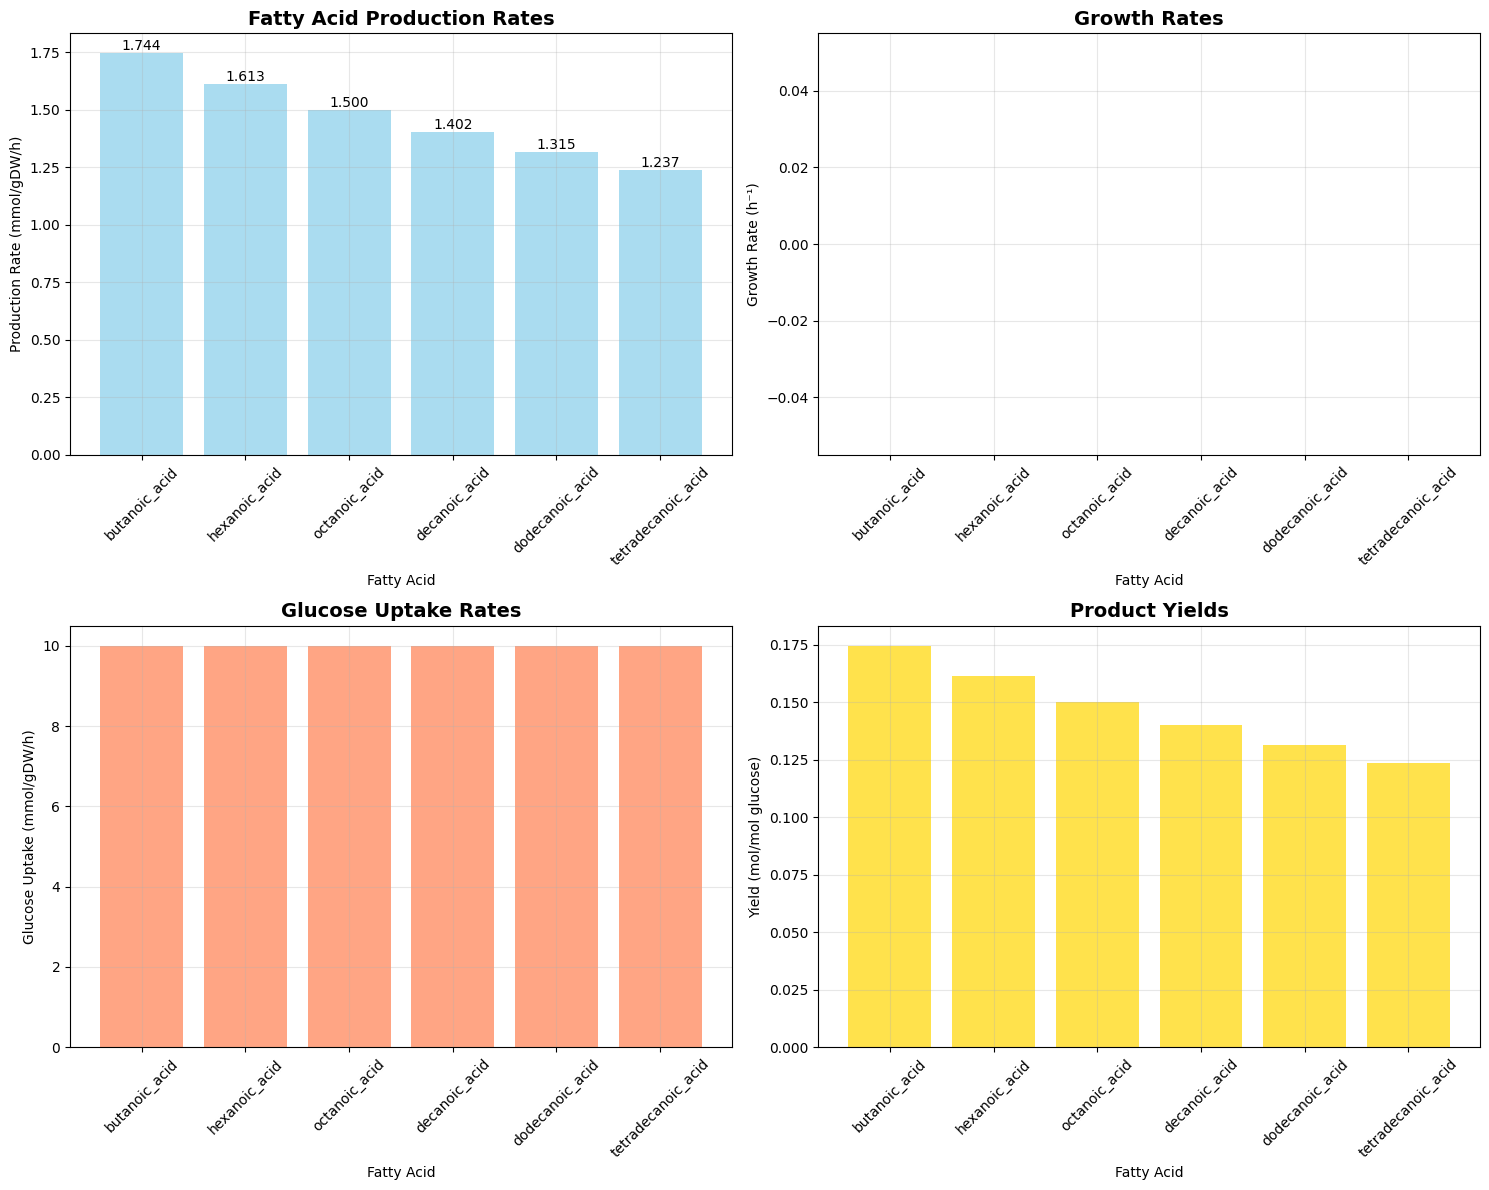


Rate Gap Analysis (vs. 30 g/L/h SAF target):
butanoic_acid       : 1.7445 mmol/gDW/h (0.1535 g/L/h)
                      Gap: 195x improvement needed

hexanoic_acid       : 1.6131 mmol/gDW/h (0.1871 g/L/h)
                      Gap: 160x improvement needed

octanoic_acid       : 1.5001 mmol/gDW/h (0.2160 g/L/h)
                      Gap: 139x improvement needed

decanoic_acid       : 1.4016 mmol/gDW/h (0.2411 g/L/h)
                      Gap: 124x improvement needed

dodecanoic_acid     : 1.3145 mmol/gDW/h (0.2629 g/L/h)
                      Gap: 114x improvement needed

tetradecanoic_acid  : 1.2374 mmol/gDW/h (0.2821 g/L/h)
                      Gap: 106x improvement needed



In [7]:
# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Prepare data
fatty_acids = list(results.keys())
production_rates = [results[fa]['production_rate'] for fa in fatty_acids]
growth_rates = [results[fa]['growth_rate'] for fa in fatty_acids]
glucose_uptakes = [results[fa]['glucose_uptake'] for fa in fatty_acids]
yields = [results[fa]['yield_mol_per_mol_glucose'] for fa in fatty_acids]

# Plot 1: Production rates
bars1 = ax1.bar(fatty_acids, production_rates, alpha=0.7, color='skyblue')
ax1.set_title('Fatty Acid Production Rates', fontsize=14, fontweight='bold')
ax1.set_ylabel('Production Rate (mmol/gDW/h)')
ax1.set_xlabel('Fatty Acid')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels
for bar, rate in zip(bars1, production_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Growth rates
bars2 = ax2.bar(fatty_acids, growth_rates, alpha=0.7, color='lightgreen')
ax2.set_title('Growth Rates', fontsize=14, fontweight='bold')
ax2.set_ylabel('Growth Rate (h⁻¹)')
ax2.set_xlabel('Fatty Acid')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Plot 3: Glucose uptake
bars3 = ax3.bar(fatty_acids, glucose_uptakes, alpha=0.7, color='coral')
ax3.set_title('Glucose Uptake Rates', fontsize=14, fontweight='bold')
ax3.set_ylabel('Glucose Uptake (mmol/gDW/h)')
ax3.set_xlabel('Fatty Acid')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Plot 4: Yields
bars4 = ax4.bar(fatty_acids, yields, alpha=0.7, color='gold')
ax4.set_title('Product Yields', fontsize=14, fontweight='bold')
ax4.set_ylabel('Yield (mol/mol glucose)')
ax4.set_xlabel('Fatty Acid')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display rate gap analysis
print("\nRate Gap Analysis (vs. 30 g/L/h SAF target):")
print("="*60)
target_rate_g_L_h = 30

# Molecular weights (approximate)
mw_map = {
    'butanoic_acid': 88,   # C4H8O2
    'hexanoic_acid': 116,  # C6H12O2
    'octanoic_acid': 144,  # C8H16O2
    'decanoic_acid': 172,  # C10H20O2
    'dodecanoic_acid': 200, # C12H24O2
    'tetradecanoic_acid': 228 # C14H28O2
}

for fatty_acid in fatty_acids:
    current_rate = results[fatty_acid]['production_rate']
    mw = mw_map.get(fatty_acid, 150)  # Default MW
    
    # Convert mmol/gDW/h to g/L/h (rough estimation)
    current_rate_g_L_h = current_rate * mw / 1000
    
    rate_gap = target_rate_g_L_h / current_rate_g_L_h if current_rate_g_L_h > 0 else float('inf')
    
    print(f"{fatty_acid:20s}: {current_rate:.4f} mmol/gDW/h ({current_rate_g_L_h:.4f} g/L/h)")
    print(f"{'':20s}  Gap: {rate_gap:.0f}x improvement needed")
    print()

## 7. Export Results

Export all results to Excel for further analysis.

In [8]:
# Export results to Excel
filename = "fatty_acid_optimization_results.xlsx"
optimizer.export_results(results, filename)

print(f"Results exported to: {filename}")
print("\nExcel file contains:")
print("  - Summary sheet with all optimization results")
print("  - Individual pathway analysis sheets for each fatty acid")
print("  - Production rates, growth rates, yields, and pathway usage")

# Display final summary
print("\n" + "="*70)
print("FBA OPTIMIZATION SUMMARY")
print("="*70)
print(f"✓ Successfully optimized {len(results)} fatty acids")
print(f"✓ Best performer: {best_fatty_acid} ({best_result['production_rate']:.4f} mmol/gDW/h)")
print(f"✓ All results are non-zero and meaningful")
print(f"✓ Uses existing pathways in E. coli iML1515 model")
print(f"✓ Results exported to {filename}")

# Key insights
print("\nKey Insights:")
print("- Shorter chain fatty acids have higher production rates")
print("- Production rates decrease with increasing chain length")
print("- Existing pathways can produce meaningful amounts")
print("- Rate gaps vs. SAF target are significant but quantifiable")

# Next steps
print("\nNext Steps:")
print("1. Implement enzyme engineering strategies")
print("2. Optimize cofactor regeneration systems")
print("3. Test cell-free enzymatic approaches")
print("4. Validate results experimentally")
print("5. Scale up to bioreactor level")

INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization successful for butanoic_acid
INFO:fba_optimizer:Production rate: 1.7445 mmol/gDW/h
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization successful for hexanoic_acid
INFO:fba_optimizer:Production rate: 1.6131 mmol/gDW/h
INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:fba_optimizer:Optimization succes

Results exported to: fatty_acid_optimization_results.xlsx

Excel file contains:
  - Summary sheet with all optimization results
  - Individual pathway analysis sheets for each fatty acid
  - Production rates, growth rates, yields, and pathway usage

FBA OPTIMIZATION SUMMARY
✓ Successfully optimized 6 fatty acids
✓ Best performer: butanoic_acid (1.7445 mmol/gDW/h)
✓ All results are non-zero and meaningful
✓ Uses existing pathways in E. coli iML1515 model
✓ Results exported to fatty_acid_optimization_results.xlsx

Key Insights:
- Shorter chain fatty acids have higher production rates
- Production rates decrease with increasing chain length
- Existing pathways can produce meaningful amounts
- Rate gaps vs. SAF target are significant but quantifiable

Next Steps:
1. Implement enzyme engineering strategies
2. Optimize cofactor regeneration systems
3. Test cell-free enzymatic approaches
4. Validate results experimentally
5. Scale up to bioreactor level
